## Sandbox for experiments and tests

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## networkX

In [2]:
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
plt.rcParams["figure.figsize"] = [20,10]

In [3]:
raw_data = pd.read_csv("data/t1.csv", delimiter=";").fillna(0.0)
raw_data.head(5)

,ID,Name,Journal,Date,Debit,Credit
0,1,Trade Receivables,Sales ledger,01/01/2017,121.0,0.0
1,1,Revenue,Sales ledger,01/01/2017,0.0,100.0
2,1,Tax,Sales ledger,01/01/2017,0.0,21.0
3,2,Cost of Sales,Journal ledger,01/01/2017,80.0,0.0
4,2,Inventories,Journal ledger,01/01/2017,0.0,80.0


In [4]:
# TODO try another kind of normalization, unit-normal etc.
def normalize(df, by="ID"):
    dfN = df.copy()
    titles = ["Debit", "Credit"]
    groups = dfN.groupby(by)
    sums = groups[titles].transform(np.sum)
    for column in titles:
        dfN[column] = dfN[column]/sums[column]
    dfN["from"] = dfN["Credit"] > 0.0
    return dfN

data = normalize(raw_data)
data.head(5)

,ID,Name,Journal,Date,Debit,Credit,from
0,1,Trade Receivables,Sales ledger,01/01/2017,1.0,0.000000,False
1,1,Revenue,Sales ledger,01/01/2017,0.0,0.826446,True
2,1,Tax,Sales ledger,01/01/2017,0.0,0.173554,True
3,2,Cost of Sales,Journal ledger,01/01/2017,1.0,0.000000,False
4,2,Inventories,Journal ledger,01/01/2017,0.0,1.000000,True


In [5]:
def construct_graph(df):
        B = nx.DiGraph()
        B.add_nodes_from(df['ID'], bipartite=0)
        B.add_nodes_from(df['Name'], bipartite=1)
        B.add_weighted_edges_from(
            [(row['Name'], row['ID'], row["Credit"]) if row["from"]==True 
             else (row['ID'], row['Name'], row["Debit"]) 
             for idx, row in df.iterrows()], 
            weight='weight')
        return B

def plot_network(B, edges_label=True, title=None):
    colors = {0: "Blue", 1: "Red"}
    left = {n for n, d in B.nodes(data=True) if d['bipartite']==1}
    pos = nx.bipartite_layout(B, left)
    arc_weight=nx.get_edge_attributes(B,'weight')
    node_col = ["Red" if d['bipartite']==0 else "Blue" for n, d in B.nodes(data=True)]
    nx.draw(B, pos, node_color= node_col, with_labels=False, node_size=250)
    nx.draw_networkx_edges(B, pos, arrowsize=30)
    if edges_label:
        nx.draw_networkx_edge_labels(B, pos, node_size=250, edge_labels=arc_weight, font_size=16)
#     TODO add relative align for labels
    label_pos = pos.copy()
    for p in label_pos:  # raise text positions
        label_pos[p][1] += 0.05
    nx.draw_networkx_labels(B, pos, font_size=16)
    if title is not None and isinstance(title, str):
        plt.tight_layout()
        plt.savefig("img/"+title, dpi=140, pad_inches=0.01)
    plt.show()

/Users/lex/anaconda3/envs/DL/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


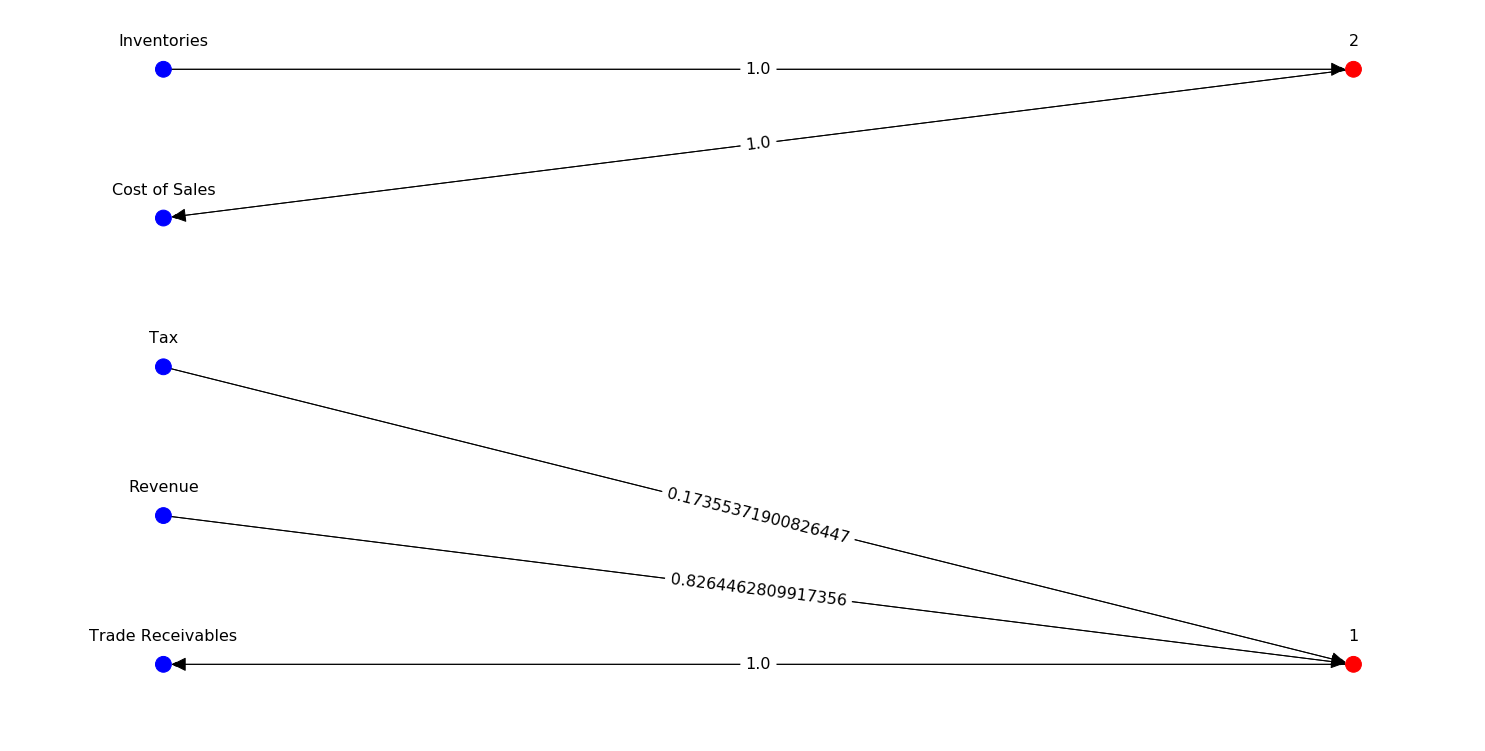

In [7]:
plot_network(construct_graph(data), title="test")

### Connection to Marcel's DB

Debit == +positive \\
Credit == -negative

In [ ]:
def upload_data(cnx, limit=10):
    # Loading data from db
    if isinstance(limit, int):
        db_data = pd.read_sql_query("SELECT * FROM EntryRecords LIMIT "+str(limit), cnx).drop(["ID", "ValueIncorrect"], axis=1)
    else:
        db_data = pd.read_sql_query("SELECT * FROM EntryRecords", cnx).drop(["ID", "ValueIncorrect"], axis=1)
    # Split into two columns: Debit and Credit
    db_data["Debit"] = db_data["ValueCorrect"][db_data["ValueCorrect"] > 0.0]
    db_data["Credit"] = -db_data["ValueCorrect"][db_data["ValueCorrect"] < 0.0]
    db_data.fillna(0.0, inplace=True)
    db_data.rename(index=str, columns={"TID": "ID"}, inplace=True)
    return db_data

In [ ]:
import sqlite3
# Create your connection.
cnx = sqlite3.connect('DataSimulation/Sample.db')

db_data = normalize(upload_data(cnx))
db_data[["ID", "Name", "Debit", "Credit"]].head(10)

In [ ]:
plot_network(construct_graph(db_data))

In [ ]:
G = construct_graph(db_data)
# TODO optimize if initial vertex is equal the destination vertex
def step(G, vertex, d="IN"):
    ws = list()
    if d=="IN":
            ins = G.in_edges(vertex, data=True)
            if len(ins)>0:
                ws = [edge[-1]["weight"] for edge in ins]
                ws = ws/np.sum(ws)
                ins = [edge[0] for edge in ins]
                return np.random.choice(ins, p=ws)
            else:
                return -1
    elif d=="OUT":
            ins = G.out_edges(vertex, data=True)
            if len(ins)>0:
                ws = [edge[-1]["weight"] for edge in ins]
                ws = ws/np.sum(ws)
                ins = [edge[1] for edge in ins]
                return np.random.choice(ins, p=ws)
            else:
                return -1
# -------
from collections import Counter
cnt = Counter([step(G, step(G, 1), d="OUT") for _ in range(30)])
cnt

In [ ]:
import random
def getNeighbors(G, vetrtex):
    return list(G.successors(vertex))+list(G.predecessors(vertex))
def randomWalk(G, vertex=None, lenght=1, direction="IN"):
    attempts = 10
    mask = {"IN": "OUT", "OUT": "IN"}
    context = list()
    if vertex is None:
        context.append(random.choice(list(G.nodes)))
    else:
        context.append(vertex)
    cur_v = context[-1]
    while len(context)<lenght+1 and attempts>0:
        try:
            new_v = step(G, step(G, cur_v, d=direction), d=mask[direction])
            attempts-=1
        except nx.NetworkXError:
            break
        if new_v!=cur_v:
            context.append(new_v)
            cur_v = new_v
    return context
# ------
randomWalk(G, vertex="Trade receivables", direction="IN")

In [ ]:
def plot_Neighbors(B, cur_v, direction="IN", edges_label=True):
    colors = {0: "Blue", 1: "Red"}
    left = {n for n, d in B.nodes(data=True) if d['bipartite']==1}
    pos = nx.bipartite_layout(B, left)
    arc_weight=nx.get_edge_attributes(B,'weight')
    node_col = ["Red" if d['bipartite']==0 else "Blue" for n, d in B.nodes(data=True)]
    nx.draw(B, pos, node_color= node_col, with_labels=False, node_size=250)
    nx.draw_networkx_edges(B, pos, arrowsize=30)
    if edges_label:
        nx.draw_networkx_edge_labels(B, pos, node_size=250, edge_labels=arc_weight, font_size=16)
#     Getting neighborhood for current vertex
    context = randomWalk(B, vertex=cur_v, direction=direction)
    print(direction, "for ", context[0], ": ", context[1:])
    nx.draw_networkx_nodes(B,pos,
                       nodelist=context[1:],
                       node_color='green',
                       node_size=300)
    nx.draw_networkx_nodes(B,pos,
                       nodelist=context[0:1],
                       node_color='green',
                       node_size=300,
                    node_shape="s")
#     TODO add relative align for labels
    label_pos = pos.copy()
    for p in label_pos:  # raise text positions
        label_pos[p][1] += 0.05
    nx.draw_networkx_labels(B, label_pos, font_size=16)
    plt.show()
# -----
plot_Neighbors(G, 1, direction="IN")

## Analysis of data sample

In [ ]:
def plot_degree_dist(graph, bp=False):
    if not bp:
        degree_sequence = sorted([d for n, d in graph.in_degree()], reverse=True)  # degree sequence
    else:
        left = {n for n, d in graph.nodes(data=True) if d['bipartite']==0}
        degree_sequence = sorted([d for n, d in graph.in_degree(left)], reverse=True)
    # print "Degree sequence", degree_sequence
    degreeCount = Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='skyblue', label="IN degree")
    if not bp:
        degree_sequence = sorted([d for n, d in graph.out_degree()], reverse=True)  # degree sequence
    else:
        degree_sequence = sorted([d for n, d in graph.out_degree(left)], reverse=True)
    # print "Degree sequence", degree_sequence
    degreeCount = Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    plt.bar(deg, cnt, width=0.80, color='coral', label="OUT degree", alpha=0.5)
    if not bp:
        plt.title("Degree Histogram")
    else:
         plt.title("Degree Histogram for BP nodes")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d for d in deg])
    ax.set_xticklabels(deg)
    plt.legend(loc="best", fontsize=20, frameon=False)
    plt.show()

In [ ]:
BigG = construct_graph(normalize(upload_data(cnx, limit=100)))
plot_degree_dist(BigG)

In [ ]:
plot_degree_dist(BigG, bp=True)

In [ ]:
import operator
sorted_nodes = {n:d for n, d in BigG.out_degree()}
sorted_nodes = sorted(sorted_nodes.items(), key=operator.itemgetter(1), reverse=True)
sorted_nodes[:15]

In [ ]:
#     Getting neighborhood for current vertex
context = randomWalk(BigG, vertex=251, direction="OUT")
print("OUT", "for ", context[0], ": ", context[1:])